## Distribution Errors

In [19]:

import torch
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
from BronchoTrack.metrics import DirectionError, EuclideanDistance, NeedleError

from matplotlib.ticker import PercentFormatter


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 15,
    "font.size": 15,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.bottom" : True, 
    "ytick.left" : True,
    "axes.spines.bottom": True,
    "axes.spines.left": True,
    "axes.spines.right": True,
    "axes.spines.top": True,
}

plt.rcParams.update(tex_fonts)

def compute_errors(data_vector):
    angles = torch.tensor(data_vector[3:6], dtype=torch.float32)
    pos = torch.tensor(data_vector[0:3], dtype=torch.float32)
    all_pa = torch.tensor(data_vector[0:6], dtype=torch.float32)
    ground = torch.zeros(3, dtype=torch.float32)
    ground_a = torch.ones(3, dtype=torch.float32)
    ground_extra = torch.zeros(6, dtype=torch.float32)
    de = DirectionError.inverse_cos(ground_a, angles).numpy()
    pe = EuclideanDistance.euclidean(ground, pos).numpy()
    ne = NeedleError.needle(ground_extra, all_pa).numpy()
    return [de, pe, ne]

def compute_distribution(globfolder):
    errors = []
    for csv in glob.glob(globfolder):
        df = pd.read_csv(csv, index_col=0).iloc[1:, -6:].values
        errors.append(np.apply_along_axis(compute_errors, 1, df))
    return np.concatenate(errors, 0)

In [91]:
train_errors = compute_distribution("../data/cleaned/train/*.csv")
val_errors = compute_distribution("../data/cleaned/val/*.csv")
test_errors = compute_distribution("../data/cleaned/test/*.csv")

In [92]:
def plot_error_dist(index, savepath, xlabel, ylabel=True):
    fig, ax = plt.subplots(figsize=(8, 6))
    # ax = sns.distplot(train_errors[:, index], bins=100, hist=False, kde_kws={"shade":True, "linewidth":1}, label="Train", ax=ax)
    ax = sns.kdeplot(train_errors[:, index], shade=True, linewidth=1, label="Train", ax=ax)
    ax = sns.kdeplot(test_errors[:, index],  shade=True, linewidth=1,label="Test", ax=ax)
    ax = sns.kdeplot(val_errors[:, index],  shade=True, linewidth=1, label="Val", ax=ax)
    ax.yaxis.set_major_formatter(PercentFormatter(1 / 0.01))
    # ax = sns.histplot(data=penguins, x="flipper_length_mm", kde=True, stat="probability", color="r", label="Probabilities",
    #          binwidth=binwidth, ax=ax1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4)
    plt.legend(fontsize=20)
    plt.xlabel(xlabel, fontsize=30)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    if ylabel:
        plt.ylabel('Density', fontsize=30)
    else:
        ax.set(ylabel=None)
    plt.tight_layout()
    fig.savefig(savepath, format='pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


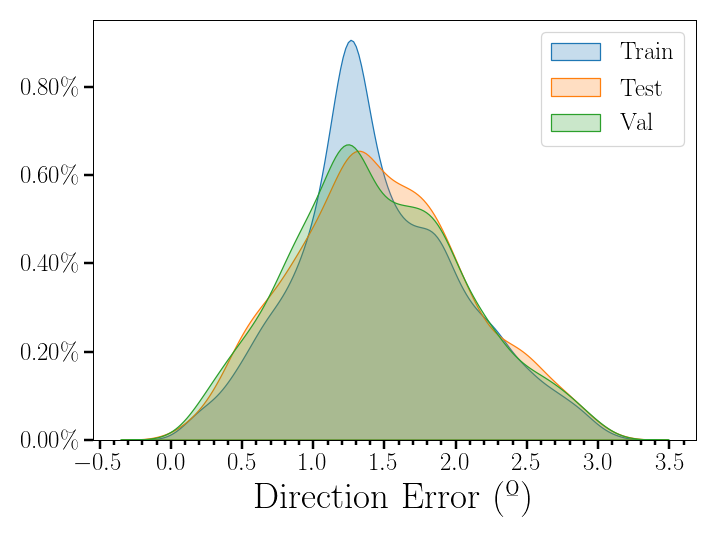

<IPython.core.display.Javascript object>


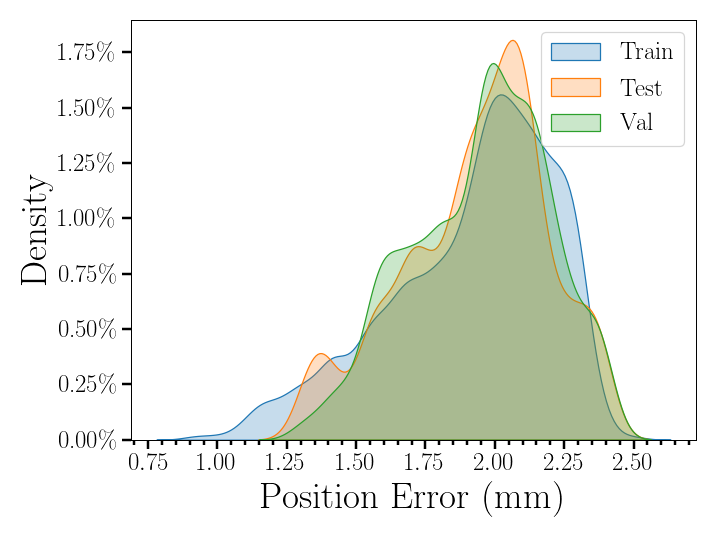

<IPython.core.display.Javascript object>


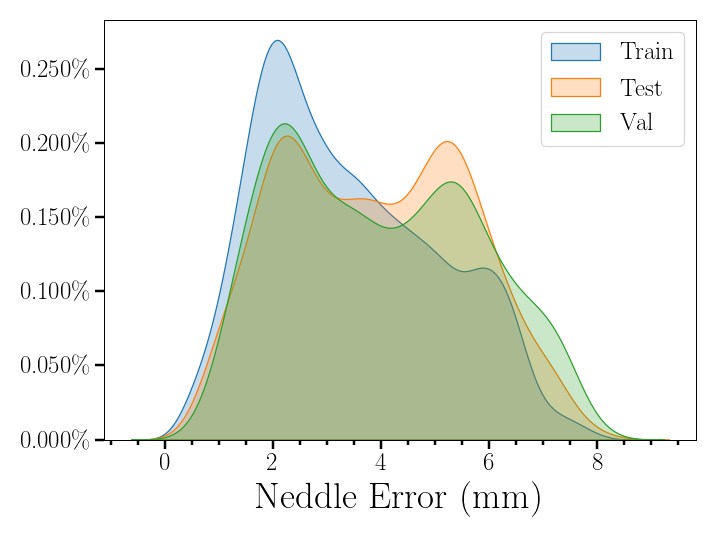

In [93]:
plot_error_dist(0, "de.pdf", "Direction Error (º)", False)
plot_error_dist(1, "pe.pdf", "Position Error (mm)", True)
plot_error_dist(2, "ne.pdf", "Neddle Error (mm)", False)

# Sample trajectories

In [94]:
%matplotlib notebook
def paths(globfolder, train=False, lobe="ur"):
    errors = []
    for csv in glob.glob(globfolder):
        if train:
            if "P25" in csv and lobe in csv:
                df = pd.read_csv(csv, index_col=0).iloc[1:, 2:5].values
                errors.append(df)
        else:
            df = pd.read_csv(csv, index_col=0).iloc[1:, 2:5].values
            errors.append(df)
    return np.concatenate(errors, 0)

In [95]:
test_paths = paths("../data/cleaned/test/*.csv")
val_paths = paths("../data/cleaned/val/*.csv")
train_paths = paths("../data/cleaned/train/*.csv", True, "ur")
train_paths_bl = paths("../data/cleaned/train/*.csv", True, "bl")
train_paths_ul = paths("../data/cleaned/train/*.csv", True, "ul")
train_paths_br = paths("../data/cleaned/train/*.csv", True, "br")


<IPython.core.display.Javascript object>


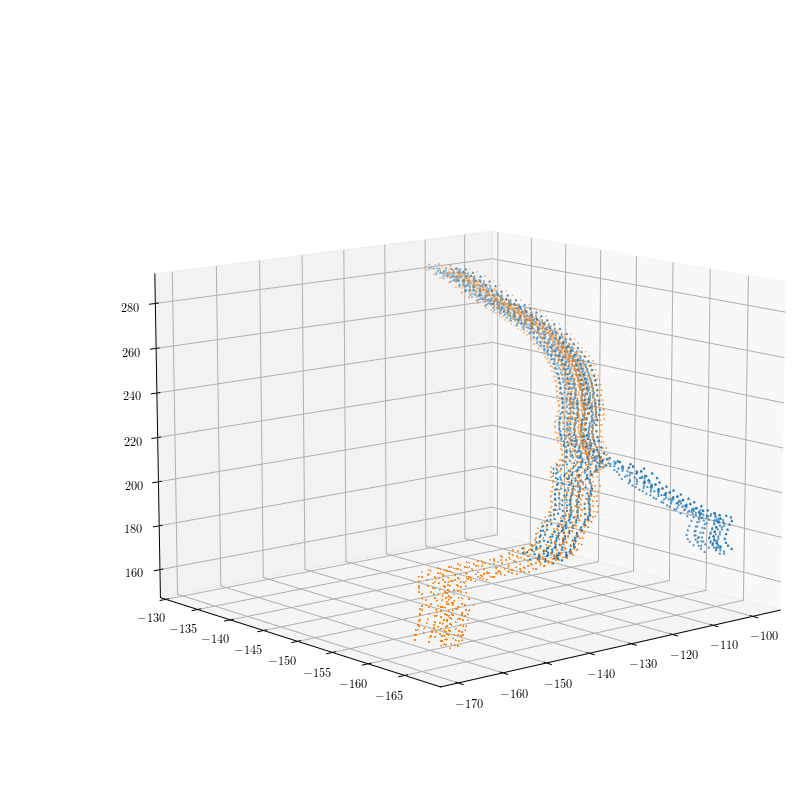

In [96]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(test_paths[:, 0], test_paths[:, 1], test_paths[:, 2], marker="^",s=1)
ax.scatter(val_paths[:, 0], val_paths[:, 1], val_paths[:, 2], marker="+",s=1)
ax.view_init(30, 200)

<IPython.core.display.Javascript object>


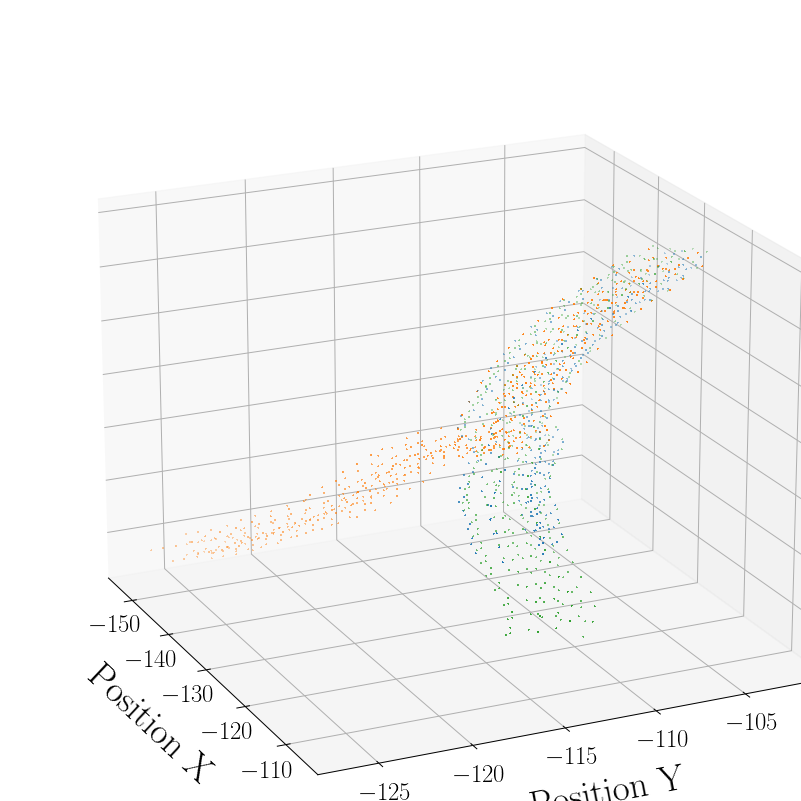

In [97]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
#ax.scatter(test_paths[:, 0], test_paths[:, 1], test_paths[:, 2], marker="^",s=1)
#ax.scatter(val_paths[:, 0], val_paths[:, 1], val_paths[:, 2], marker="+",s=1)
ax.scatter(train_paths[:, 0], train_paths[:, 1], train_paths[:, 2], marker="+",s=1)
ax.scatter(train_paths_bl[:, 0], train_paths_bl[:, 1], train_paths_bl[:, 2], marker="+",s=1)
ax.scatter(train_paths_br[:, 0], train_paths_br[:, 1], train_paths_br[:, 2], marker="+", s=1)
#ax.scatter(train_paths_ur[:, 0], train_paths_ur[:, 1], train_paths_ur[:, 2], marker="b^", s=1)

ax.view_init(20, -25)
ax.set_ylabel("Position Y", fontsize=30, labelpad=20)
ax.set_xlabel("Position X", fontsize=30, labelpad=20)
ax.set_zlabel("Position Z", fontsize=30, labelpad=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.zaxis.set_tick_params(labelsize=20)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
fig.savefig("sample_traj.pdf", format='pdf', bbox_inches='tight')

# N Images

In [98]:
def compute_len(globfolder):
    errors = []
    for csv in glob.glob(globfolder):
        df = pd.read_csv(csv, index_col=0).iloc[1:, -6:].values
        errors.append(len(df))
    return np.sum(errors)

In [99]:
compute_len("../data/cleaned/test/*.csv"), compute_len("../data/cleaned/train/*.csv"),  compute_len("../data/cleaned/val/*.csv")

(1890, 10440, 1800)

# Draw Central Paths

In [100]:
from collections import defaultdict
root = "/mnt/DADES/datasetcalibracio/"
patients = ["P25", "P18", "P20", "P21", "P30"]
lobes = ["ur", "ul", "br", "bl"]
columns_use = ["pos_x", "pos_y", "pos_z"]

In [101]:
def get_central_paths():
    patient_dict = defaultdict(dict)
    for p in patients:
        for csv in glob.glob(os.path.join(root, "*" + p + "*CPAP.csv")):
            sample_df = pd.read_csv(csv)
            for lobe in lobes:
                lobe_df = sample_df[sample_df["lobe"] == lobe].copy().reset_index()
                lobe_df["isStatusChanged"] = lobe_df["base_filename"].shift(
                    1, fill_value=lobe_df["base_filename"].head(1)) != lobe_df["base_filename"]
                change_indexes = np.insert(
                    lobe_df.loc[lobe_df["isStatusChanged"], :].index.values, 0, 0)
                seq_level_lobe_df = lobe_df.loc[
                    change_indexes, columns_use,
                ].copy().reset_index().values
                patient_dict[p][lobe] = seq_level_lobe_df
    return patient_dict

In [102]:
patient_dict = get_central_paths()

In [103]:
patient_dict["P25"]["bl"]

array([[    0.   ,  -124.54 ,  -103.436,   166.979],
       [  876.   ,  -124.852,  -104.244,   165.417],
       [ 1752.   ,  -124.939,  -105.306,   163.601],
       [ 2628.   ,  -125.069,  -106.001,   161.862],
       [ 3504.   ,  -125.47 ,  -106.932,   160.198],
       [ 4380.   ,  -125.629,  -107.483,   158.846],
       [ 5256.   ,  -125.788,  -108.222,   156.827],
       [ 6132.   ,  -125.844,  -109.057,   154.742],
       [ 7008.   ,  -125.829,  -109.871,   152.688],
       [ 7884.   ,  -125.805,  -110.503,   150.578],
       [ 8760.   ,  -125.844,  -110.974,   148.972],
       [ 9636.   ,  -125.999,  -111.349,   147.012],
       [10512.   ,  -126.301,  -111.509,   145.291],
       [11388.   ,  -126.386,  -111.928,   143.588],
       [12264.   ,  -126.237,  -112.383,   141.492],
       [13140.   ,  -125.66 ,  -112.738,   139.476],
       [14016.   ,  -125.717,  -112.601,   137.513],
       [14892.   ,  -126.604,  -112.66 ,   135.973],
       [15768.   ,  -127.918,  -113.166,   135

<IPython.core.display.Javascript object>


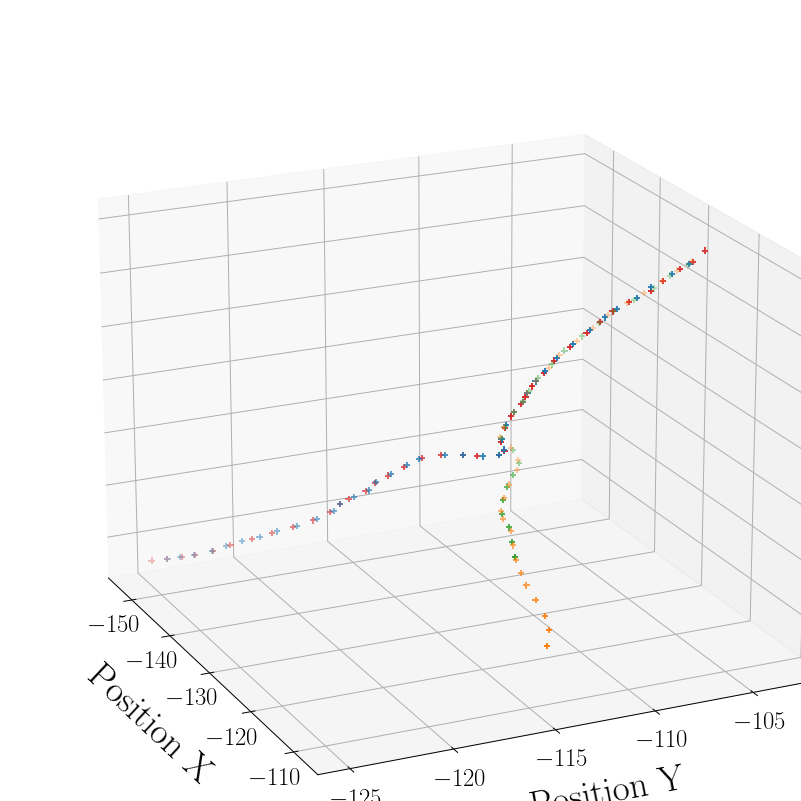

In [104]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(patient_dict["P25"]["bl"][:, 1], patient_dict["P25"]["bl"][:, 2], patient_dict["P25"]["bl"][:, 3], marker="+",s=25)
ax.scatter(patient_dict["P25"]["br"][:, 1], patient_dict["P25"]["br"][:, 2], patient_dict["P25"]["br"][:, 3], marker="+",s=25)
ax.scatter(patient_dict["P25"]["ur"][:, 1], patient_dict["P25"]["ur"][:, 2], patient_dict["P25"]["ur"][:, 3], marker="+",s=25)
ax.scatter(patient_dict["P25"]["ul"][:, 1], patient_dict["P25"]["ul"][:, 2], patient_dict["P25"]["ul"][:, 3], marker="+",s=25)
#ax.scatter(train_paths_bl[:, 0], train_paths_bl[:, 1], train_paths_bl[:, 2], marker="+",s=1)
#ax.scatter(train_paths_br[:, 0], train_paths_br[:, 1], train_paths_br[:, 2], marker="+", s=1)
#ax.scatter(train_paths_ur[:, 0], train_paths_ur[:, 1], train_paths_ur[:, 2], marker="b^", s=1)

ax.view_init(20, -25)
ax.set_ylabel("Position Y", fontsize=30, labelpad=20)
ax.set_xlabel("Position X", fontsize=30, labelpad=20)
ax.set_zlabel("Position Z", fontsize=30, labelpad=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.zaxis.set_tick_params(labelsize=20)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
fig.savefig("sample_traj.pdf", format='pdf', bbox_inches='tight')

# Losses

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

tex_fonts = {
    # Use LaTeX to write all text
    "font.family": "serif",
}

plt.rcParams.update(tex_fonts)


In [5]:
cosin = pd.read_csv("run-BronchoModelLossP18_1_bronchonet_15traj_COS-tag-Train Direction Error.csv")
de = pd.read_csv("run-BronchoModelLossP18_1_bronchonet_15traj_DE-tag-Train Direction Error.csv")
mse = pd.read_csv("run-BronchoModelLossP18_1_bronchonet_15traj_MSE-tag-Train Direction Error.csv")
quaternion = pd.read_csv("run-BronchoModelLossP18_1_bronchonet_15traj_QUAT-tag-Train Direction Error.csv")


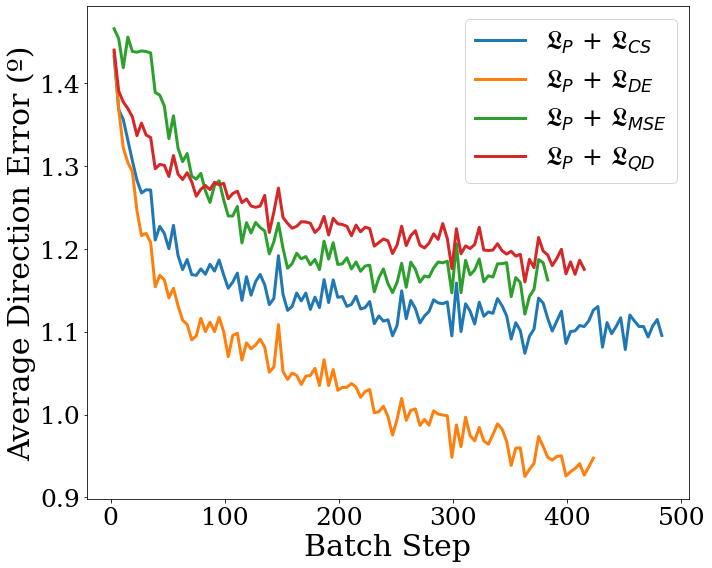

In [18]:
plt.figure(figsize=(10,8))
plt.plot(cosin["Step"], cosin["Value"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{CS}$', lw=3)
plt.plot(de["Step"], de["Value"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{DE}$ ', lw=3)
plt.plot(mse["Step"], mse["Value"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{MSE}$', lw=3)
plt.plot(quaternion["Step"], quaternion["Value"], label='$\mathfrak{L}_{P}$ + $\mathfrak{L}_{QD}$', lw=3)
plt.legend(fontsize=25)
plt.ylabel("Average Direction Error (º)", fontsize=30)
plt.xlabel("Batch Step", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.tight_layout()
plt.savefig("loss_plot.pdf", format='pdf', bbox_inches='tight')